In [1]:
import os

import pandas as pd
import numpy as np

import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.windows import from_bounds
import xarray as xr
import rioxarray as rioxr

import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import latex

import yaml

from utils import geo, data

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import atlite
from atlite.gis import ExclusionContainer

import matplotlib.pyplot as plt; plt.style.use('seaborn-colorblind')
import matplotlib.colors as pltc
import contextily as cx
import style; figsize = style.configure(document_fontsize = 10.95, available_width = 394.78204)
from style import lighten_color

## Notebook to replicate the key analysis steps of the Masterthesis
#### Order and numbering according to Table of Contents in Masterthesis document

## 0 . Preliminaries

In [2]:
# Define PATH that leads to data folder

ROOT = 'C:/Users/49176/Uni/Masterthesis/'
LUISA = ROOT + 'data/input_geodata/luisa.tif'
CORINE = ROOT + 'data/input_geodata/corine.tif'

# Excel with necessary information the country gridcodes to work with LUISA 
gc_excel = pd.read_excel(ROOT + 'data/gridcode_dict.xlsx', sheet_name = 'py_dict_format', 
                         converters = {'in_gc_luisa' : int, 'in_gc_corine' : int, 'ex_gc_luisa' : int, 'ex_gc_corine': int})

gridcodes = {
    'inclusion' : 
    {
        'luisa' : dict(zip(gc_excel['in_gc_type'], gc_excel['in_gc_luisa'])),
        'corine' : dict(zip(gc_excel['in_gc_type'], gc_excel['in_gc_corine']))
    },
    'exclusion' :
    {
        'luisa' : dict(zip(gc_excel['ex_gc_type_luisa'].dropna(), gc_excel['ex_gc_luisa'].dropna())),
        'corine' : dict(zip(gc_excel['ex_gc_type_corine'].dropna(), gc_excel['ex_gc_corine'].dropna()))
    }
}

clrs = {'darkblue' : plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
         'green' : plt.rcParams['axes.prop_cycle'].by_key()['color'][1],
         'orange' : plt.rcParams['axes.prop_cycle'].by_key()['color'][2],
         'pink' : plt.rcParams['axes.prop_cycle'].by_key()['color'][3],
         'yellow' : plt.rcParams['axes.prop_cycle'].by_key()['color'][4],
         'lightblue' : plt.rcParams['axes.prop_cycle'].by_key()['color'][5]}


## 3. Data

### Fig 3.1 Pyhsical Potential

In [113]:
countries = ['France', 'Spain', 'Italy', 'Switzerland', 'Germany', 'Belgium']
shp = [gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg') for cntry in countries]

In [ ]:
src = []
root = ROOT + f'data/era5/France/'

for i in pd.date_range('2011' , '2022', freq = 'Y').strftime('%Y'): 
    
    src.append(f'{root}{i}.nc')            
               
cutout = geo.merge_cutouts(src)
wnd100m = cutout.data['wnd100m']

In [115]:
gwa = rioxr.open_rasterio(ROOT + 'data/gwa/France_wind-speed_100m.tif') 

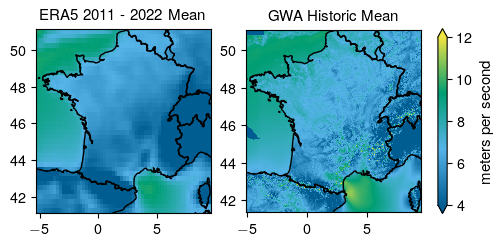

In [19]:
cmap = pltc.LinearSegmentedColormap.from_list("", [lighten_color(clrs['darkblue'],1.1), clrs['lightblue'], clrs['green'] ,clrs['yellow']])

fig, ax = plt.subplots(1,2,figsize = figsize(1), dpi = 100)


cbar_kwargs = {'label':'meters per second'}

# Era5
era = wnd100m.mean('time').plot(cmap = cmap, ax=ax[0],  add_colorbar = False, vmin = 4, vmax = 12)
for country in shp:
    country.plot(facecolor = 'none', edgecolor ='k',  ax=ax[0]) 
    
ax[0].set_ylabel(None); ax[0].set_xlabel(None)
ax[0].set_title('ERA5 2011 - 2022 Mean') 


# GWA
glowa = gwa.plot(cmap = cmap, ax=ax[1], add_colorbar = False, vmin = 4, vmax = 12)

for country in shp:
    country.plot(facecolor = 'none', edgecolor ='k', ax=ax[1])
    
ax[1].set_xlim(shp[0].unary_union.bounds[0], shp[0].unary_union.bounds[2])
ax[1].set_ylim(shp[0].unary_union.bounds[1], shp[0].unary_union.bounds[3])

ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title('GWA Historic Mean')

cbar = plt.colorbar(era, ax=ax.ravel().tolist(), shrink = 0.725, extend='both', fraction=0.05, pad=0.04, label = 'meters per second')
 

#fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/era5_gwa.png', dpi = 200, facecolor = 'white')

### Fig. 3.2

In [ ]:
#States
shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_1_states_provinces_lines')
    
states = gpd.read_file(shpfilename)[['ADM0_NAME', 'NAME', 'geometry']]
berlin = states.to_crs(3035).query("NAME == 'Berlin - Brandenburg'")

In [20]:
buffer = 5000

with rio.open(LUISA) as f:
    
    window = from_bounds(berlin.bounds['minx'].values - buffer,
                         berlin.bounds['miny'].values - buffer,
                         berlin.bounds['maxx'].values + buffer,
                         berlin.bounds['maxy'].values + buffer,
                         f.transform)
    
    luisa = f.read(1, window = window)
    transform_luisa = rio.windows.transform(window, f.transform)
    
    
with rio.open(CORINE) as f:
    
    window = from_bounds(berlin.bounds['minx'].values - buffer,
                         berlin.bounds['miny'].values - buffer,
                         berlin.bounds['maxx'].values + buffer,
                         berlin.bounds['maxy'].values + buffer,
                         f.transform)
    
    corine = f.read(1, window = window)
    transform_corine = rio.windows.transform(window, f.transform)
    
luisa_labs_cols = {'High density urban fabric' : clrs['darkblue'],
                   'Medium density urban fabric' : style.lighten_color(clrs['green'], 1.25), 
                   'Low density urban fabric' : clrs['green'],
                   'Isolated or very low density urban fabric' : style.lighten_color(clrs['green'], 0.75),              
                   'Industrial or commercial units' : clrs['orange'],
                   'Road and rail networks and associated land' : style.lighten_color(clrs['orange'], 1.25)}
    
corine_labs_cols = {'Continuous urban fabric' : clrs['darkblue'],
                    'Discontinuous urban fabric' : clrs['green'], 
                    'Industrial or commercial units' : clrs['orange'],
                    'Road and rail networks and associated land' : style.lighten_color(clrs['orange'], 1.25)}    

gc_luisa = [gridcodes['exclusion']['luisa'][i] for i in luisa_labs_cols.keys()]
gc_corine = [gridcodes['exclusion']['corine'][i] for i in corine_labs_cols.keys()]
    
luisa_plot = np.isin(luisa, [gc_luisa])  * luisa
corine_plot = np.isin(corine, [gc_corine])  * corine

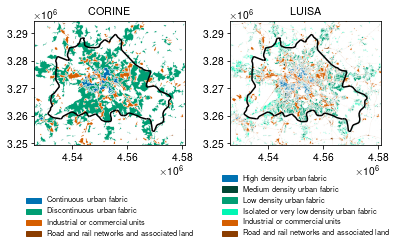

In [26]:
c_transparent = pltc.colorConverter.to_rgba('white',alpha = 0)

fig, ax = plt.subplots(1 , 2, figsize=figsize(1)) 

#left plot
patches = []

for g,l,c in zip(gc_corine, corine_labs_cols.keys(), corine_labs_cols.values()):
               
    cmap = pltc.LinearSegmentedColormap.from_list('rb_cmap',[c_transparent, c],512)
               

    show(np.isin(corine_plot, [g]) , transform = transform_corine, cmap = cmap, label = l, ax=ax[0])

    
patches = [mpatches.Patch(color=c, label=l) for l,c in zip(corine_labs_cols.keys(), corine_labs_cols.values())]
ax[0].legend(handles = patches, loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=1, frameon=False, fontsize = 'x-small')


berlin.plot(edgecolor = 'k', ax=ax[0])
ax[0].set_title('CORINE')


for g,l,c in zip(gc_luisa, luisa_labs_cols.keys(), luisa_labs_cols.values()):
               
    cmap = pltc.LinearSegmentedColormap.from_list('rb_cmap',[c_transparent, c],512)
               

    show(np.isin(luisa_plot, [g]) , transform = transform_luisa, cmap = cmap, label = l, ax=ax[1])
    
patches = [mpatches.Patch(color=c, label=l) for l,c in zip(luisa_labs_cols.keys(), luisa_labs_cols.values())]
ax[1].legend(handles = patches, loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=1, frameon=False,  fontsize = 'x-small')

berlin.plot(edgecolor = 'k', ax=ax[1])
ax[1].set_title('LUISA')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/corine_luisa_berlin.pdf', bbox_inches = 'tight', dpi = 1000)

## Fig 3.3

In [24]:
do = False

if do == True:


    forest_d = {'Broad-leaved forest', 'Coniferous forest', 'Mixed forest'}


    with open(ROOT + "/windgenpotential/countrycode.yaml", 'r') as stream:
        countrycode = yaml.safe_load(stream)  

    countries = [i for i in countrycode.keys()]
    d = {}

    for cntry in countries:

        country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)

        exc = ExclusionContainer(res=50)

        exc.add_raster(LUISA, codes = [gridcodes['inclusion']['luisa'][x] for x in forest_d], crs=3035, invert = True)

        forest = geo.mte(exc, country.geometry, share_kind = 'normal')

        d[cntry] = {'area' : forest[2], 'share' : forest[3]}

    forest_analysis = pd.DataFrame.from_dict(d, orient = 'index', columns = ['area', 'share'])

    #### Optional: save forest_analysis.csv
    #forest_analysis.to_csv(ROOT + 'results/landuse_forest_share.csv')

In [ ]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['green'], 1.1)])

fig, ax = plt.subplots(figsize = figsize(1), dpi = 150)


divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


for cntry in countries:
    country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    country['share'] = forest_analysis.loc[cntry, 'share'] * 100
    if cntry == countries[0]:
        country.plot('share', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 65, legend = True, ax = ax, cax=cax)

    else:
        country.plot('share', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 65, legend = False, ax = ax)
        
cax.set_ylabel('percent', rotation = 270, labelpad = 15)        
ax.set_title('Forest share per country')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/forest_share_map.pdf')
    

### Fig. 3.4

In [129]:
cdda = gpd.read_file(r'C:\CaT\Masterthesis\repository\data\input_geodata\WDPA_WDOECM_Nov2022_Public_EU\WDPA_WDOECM_Nov2022_Public_EU.gdb\a00000009.gdbtable')

C:\Users\Calvin\.conda\envs\atlite\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


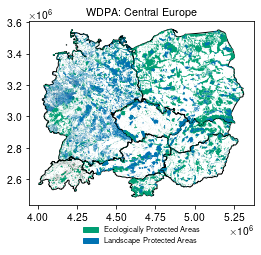

In [56]:
central_europe = ['Germany', 'Switzerland', 'Austria', 'Slovenia', 'Slovakia', 'Czech Republic', 'Hungary', 'Poland']

fig, ax = plt.subplots()

for cntry in central_europe:

    shape = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    pa =  gpd.read_file(ROOT + f'data/country_pa/{cntry}.gpkg')
    
    if cntry == 'Germany':
        shape.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
        pa[pa['IUCN_CAT'] != 'V'].plot(color = clrs['green'] , ax=ax)
        pa[pa['IUCN_CAT'] == 'V'].plot(color = clrs['darkblue'] , ax=ax)
    else:
        shape.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
        pa[pa['IUCN_CAT'] != 'V'].plot(color = clrs['green'], ax=ax)
        pa[pa['IUCN_CAT'] == 'V'].plot(color = clrs['darkblue'], ax=ax)

patches = [mpatches.Patch(color=c, label=l) for l,c in zip(['Ecologically Protected Areas', 'Landscape Protected Areas'],[clrs['green'],clrs['darkblue']])]   
ax.legend(handles = patches, loc = 'lower center', ncol = 1, bbox_to_anchor=(0.5, -0.25), frameon=False,  fontsize = 'x-small')

ax.set_title('WDPA: Central Europe')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/pa.png', facecolor='w', dpi = 500)


### Fig. 3.5

In [5]:
#Austria

country = gpd.read_file(ROOT + 'data/country_shapes/Austria.gpkg').to_crs(3035)

with rio.open(ROOT + 'data/input_geodata/EUD_CP_SLOP_mosaic/eudem_slop_3035_europe.tif') as src: 
    window = from_bounds(country.bounds['minx'].values, country.bounds['miny'].values, country.bounds['maxx'].values, country.bounds['maxy'].values, src.transform)
    slope = src.read(1, window=window)
    transform = rio.windows.transform(window, src.transform)
    
slope[slope == 0] = 250
 
slope = geo.dn_to_degrees(slope) 

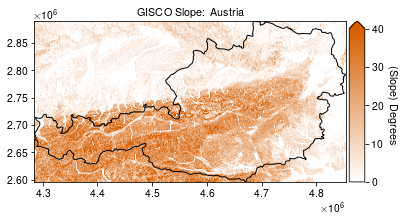

In [55]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['orange'], 1)])

fig = plt.figure(figsize = figsize(1))
ax = plt.gca()

im = show(slope, transform = transform, cmap = cmap, ax=ax, vmin = 0, vmax = 40)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)


ax.set_title('GISCO Slope: Austria')

plt.colorbar(im.get_images()[0], cax=cax, extend = 'max')
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
cax.set_ylabel('(Slope) Degrees', rotation = 270, labelpad = 15)   

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/slope.pdf', dpi = 500)

## 4. Methodology

### Fig. 4.1 

In [ ]:
country = gpd.read_file(ROOT + f'data/country_shapes/Luxembourg.gpkg').to_crs(3035)

In [130]:
exc = ExclusionContainer(res=50)

exc.add_raster(LUISA, codes = [2110], crs=3035, invert = True)

# Non irigated arable land
nial = geo.mte(exc, country.geometry, share_kind = 'normal')

C:\Users\49176\AppData\Roaming\Python\Python39\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


In [139]:
exc = ExclusionContainer(res=50)

exc.add_raster(LUISA, codes = [1122], crs=3035, invert = False, buffer = 1000)

# low density urban fabric
lduf = geo.mte(exc, country.geometry, share_kind = 'normal')

C:\Users\49176\AppData\Roaming\Python\Python39\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


In [140]:
exc = ExclusionContainer(res=50)

exc.add_raster(LUISA, codes = [2110], crs=3035, invert = True)
exc.add_raster(LUISA, codes = [1122], crs=3035, invert = False, buffer = 1000)

# Combination
comb = geo.mte(exc, country.geometry, share_kind = 'normal')

C:\Users\49176\AppData\Roaming\Python\Python39\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


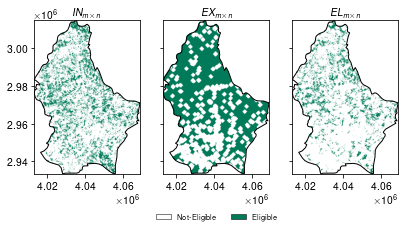

In [159]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['green'], 1.1)])


fig, ax = plt.subplots(1, 3, figsize = figsize(1), sharey = True)

show(nial[0], transform = nial[1], ax = ax[0], cmap = cmap)
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax[0])
ax[0].set_title(r'$IN_{m \times n}$')

show(lduf[0], transform = lduf[1], ax = ax[1], cmap = cmap)
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax[1])
ax[1].set_title(r'$EX_{m \times n}$')

show(comb[0], transform = comb[1], ax = ax[2], cmap = cmap)
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax[2])
ax[2].set_title(r'$EL_{m \times n}$')

patches = [mpatches.Patch(facecolor=c, edgecolor = 'k', lw = .5, label=l) for l,c in zip(['Not-Eligible', 'Eligible'],['white',lighten_color(clrs['green'], 1.1)])]   
ax[1].legend(handles = patches, loc = 'lower center', ncol = 2, bbox_to_anchor=(0.5, -0.35), frameon=False,  fontsize = 'x-small')


fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/metho_eligibility.pdf', dpi = 500)

### Fig. 4.4

In [10]:
with rio.open(ROOT + 'data/country_landuse_results/Luxembourg-base-1000-30-0-0.tif') as src: 
    el = src.read(1)
    transform = src.transform
    
with rio.open(ROOT + 'data/country_azimuth/Luxembourg-burned-azimuth.tif') as src: 
    az = src.read(1)
    
with rio.open(ROOT + 'data/country_turbine_decision/Luxembourg-Vestas_V90_3MW-Vestas_V112_3MW-burned-decision.tif') as src: 
    tt = src.read(1)

country = gpd.read_file(ROOT + 'data/country_shapes/luxembourg.gpkg')

In [5]:
turbine_dict = {1 : 90, 2 : 112}

tp = geo.place_n_turbines(res = 50,
                          landuse_av = el,
                          wind_dir = az[::-1],
                          turbine_type = tt[::-1], turbine_dict = turbine_dict,
                          r_radius_factor = 4,
                          c_radius_factor = 8,
                          return_ellipses = True)                       

Successfully built 644 turbines


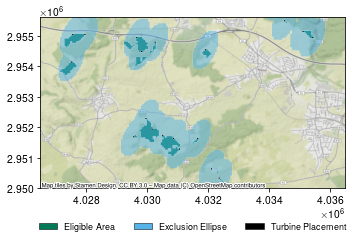

In [110]:
c_transparent = pltc.colorConverter.to_rgba('white',alpha = 0)
c_lightblue = pltc.colorConverter.to_rgba(clrs['lightblue'],alpha = .5)


cmap_el = pltc.LinearSegmentedColormap.from_list("", [c_transparent,lighten_color(clrs['green'], 1.1)])
cmap_ellipses = pltc.LinearSegmentedColormap.from_list("", [c_transparent, c_lightblue])
cmap_turbine = pltc.LinearSegmentedColormap.from_list("", [c_transparent, 'black'])



fig, ax = plt.subplots(figsize = figsize(1))


ax.set_ylim(2950000, 2955600)
ax.set_xlim(4026500, 4036500)

bm = cx.add_basemap(ax, crs = 'EPSG:3035', zoom = 14, attribution_size = 6)

#bm = ax 

show(el, transform = transform, ax = bm, cmap = cmap_el)
show(tp[2], transform = transform, ax = bm , cmap = cmap_ellipses)
show(tp[1], transform = transform, ax = bm, cmap = cmap_turbine, alpha = 1)


patches = [mpatches.Patch(facecolor=c, edgecolor = 'k', lw = .5, label=l) for l,c in zip(['Eligible Area', 'Exclusion Ellipse', 'Turbine Placement'],[lighten_color(clrs['green'], 1.1), clrs['lightblue'], 'black'])]   
ax.legend(handles = patches, loc = 'lower center', ncol = 3, bbox_to_anchor=(0.5, -0.3), frameon=False,  fontsize = 'small')


#fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/placement_example.pdf', bbox_inches = 'tight', dpi = 500)


### Fig. 4.4

In [178]:
V_w2e_165 =  [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 20]
POW_w2e_165 = [0.000, 0.000, 0.097, 0.321, 0.691, 1.237, 1.992, 2.930, 3.934, 4.649, 5.041, 5.193, 5.200, 5.200, 0]

V_w2e_151 = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 20]
POW_w2e_151 = [0.000, 0.000, 0.045, 0.2671, 0.5945, 1.0688, 1.6873, 2.483, 3.3945, 4.22555, 4.6945, 4.800, 4.800, 0]

V_V_90 = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 25]
POW_V_90 = [0.000, 0.000, 0.000, 0.065, 0.195, 0.340, 0.570, 0.880, 1.270, 1.710, 2.140, 2.540, 2.830, 2.995, 3.000, 3.000, 0.000]

V_V_112 = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 25, 25]
POW_V_112 = [0.000, 0.000, 0.005, 0.115, 0.300, 0.550, 0.945, 1.375, 1.960, 2.525, 2.950, 2.990, 3.000, 3.000, 0.000]

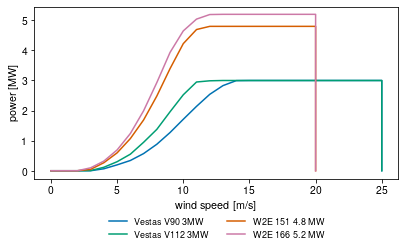

In [187]:
fig, ax = plt.subplots(figsize = figsize(1)) 

ax.plot(V_V_90, POW_V_90, label = 'Vestas V90 3MW')
ax.plot(V_V_112, POW_V_112, label = 'Vestas V112 3MW')

ax.plot(V_w2e_151, POW_w2e_151, label = 'W2E 151 4.8 MW')
ax.plot(V_w2e_165, POW_w2e_165, label = 'W2E 166 5.2 MW')

ax.set_ylabel('power [MW]')
ax.set_xlabel('wind speed [m/s]')

ax.legend(loc = 'lower center', ncol = 2, bbox_to_anchor=(0.5, -0.4), frameon=False,  fontsize = 'small')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/power_curves.pdf', bbox_inches = 'tight', dpi = 200)


## 5. Results

### Tab 5.1

In [1517]:
full_res = []

for cntry in countries:

    gwa_cf = np.load(ROOT + f'data/country_era5_gwa_cf/{cntry}.npy')

    files = glob.glob(ROOT + f'data/era5/{cntry}/' + '*.nc')
    files = [os.path.basename(file) for file in files]

    res = []

    for wy in files:

        ##1. Get y-cutout
        cutout = atlite.Cutout(path = ROOT + f'data/era5/{cntry}/{wy}')

        # Mean correction in data
        cutout.data['wnd100m'].values = cutout.data['wnd100m'].values * gwa_cf

        res.append(cutout.data['wnd100m'].mean('time'))
        
    full_res.append(sum(res)/len(res))

In [1513]:
windspeed = {}

for i,cntry in enumerate(countries):
    shape = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg')
    
    df = full_res[i].to_dataframe().reset_index()
    ws = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.lon,df.lat), crs = 4326)
    
    gwa_cf = np.load(ROOT + f'data/country_era5_gwa_cf/{cntry}.npy')
    full_res[i].data = gwa_cf
    df = full_res[i].to_dataframe().reset_index()
    gwa = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.lon,df.lat), crs = 4326)
    
    
    windspeed[cntry] = [gpd.overlay(ws, shape)['wnd100m'].mean(), gpd.overlay(ws, shape)['wnd100m'].std(), gpd.overlay(gwa, shape)['wnd100m'].mean()]
    
wind_df = pd.DataFrame(windspeed).T
round(wind_df,2).to_csv(ROOT + 'results/pyhsical_potential.csv')

### Fig. 5.1

In [208]:
# Landuse eli vars 

uds = [400, 600, 800, 1000]
slopes = [15,30]
fshares = [0, 5, 10]
lshares = [0, 5, 10]

with open(ROOT + "/windgenpotential/countrycode.yaml", 'r') as stream:
    countrycode = yaml.safe_load(stream)  

countries = [i for i in countrycode.keys()]

In [456]:
area_tot = {}

for cntry in countries: 
    v = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035).area
    area_tot[cntry] = v.values

area_tot = pd.DataFrame(area_tot).T
area_tot.columns = ['area_tot']

In [457]:
from itertools import product

lu = []

for cntry, ud, slope, fshare, lshare in product(countries, uds, slopes, fshares, lshares):

    with rio.open(ROOT + f'data/country_landuse_results/{cntry}-base-{ud}-{slope}-{fshare}-{lshare}.tif') as f:
        v = f.read(1)
        f.close()
        v_area = v.sum() * 50**2
        v_share = v_area / area_tot.loc[cntry].values[0]
                                                
        lu.append([cntry, ud, slope, fshare, lshare, v_area, v_share])
        
lu = pd.DataFrame(lu, columns = ['country', 'ud', 'slope', 'fshare', 'lshare', 'v_area', 'v_share'])

#lu.to_csv(ROOT+'results/geographic_potential.csv')

In [711]:
lu_ud = lu[['country', 'ud', 'v_share']].groupby(['country', 'ud']).mean().unstack()
lu_slope = lu[['country', 'slope', 'v_share']].groupby(['country', 'slope']).mean().unstack()
lu_fshare = lu[['country', 'fshare', 'v_share']].groupby(['country', 'fshare']).mean().unstack()
lu_lshare = lu[['country', 'lshare', 'v_share']].groupby(['country', 'lshare']).mean().unstack()

In [712]:
def divide_by_first(row):
    return (row / row[0]) 
    
lu_ud_mod = lu_ud.iloc[:, ::-1].apply(divide_by_first, axis=1)
lu_slope_mod = lu_slope.apply(divide_by_first, axis=1)
lu_fshare_mod = lu_fshare.apply(divide_by_first, axis=1)
lu_lshare_mod = lu_lshare.apply(divide_by_first, axis=1)

In [713]:
min_max = pd.concat([lu[['country', 'ud', 'v_share']].groupby(['country', 'ud']).min().unstack().iloc[:,3],
                    lu[['country', 'ud', 'v_share']].groupby(['country', 'ud']).max().unstack().iloc[:,0]], axis = 1)
min_max['diff'] = min_max.iloc[:,1] - min_max.iloc[:,0]

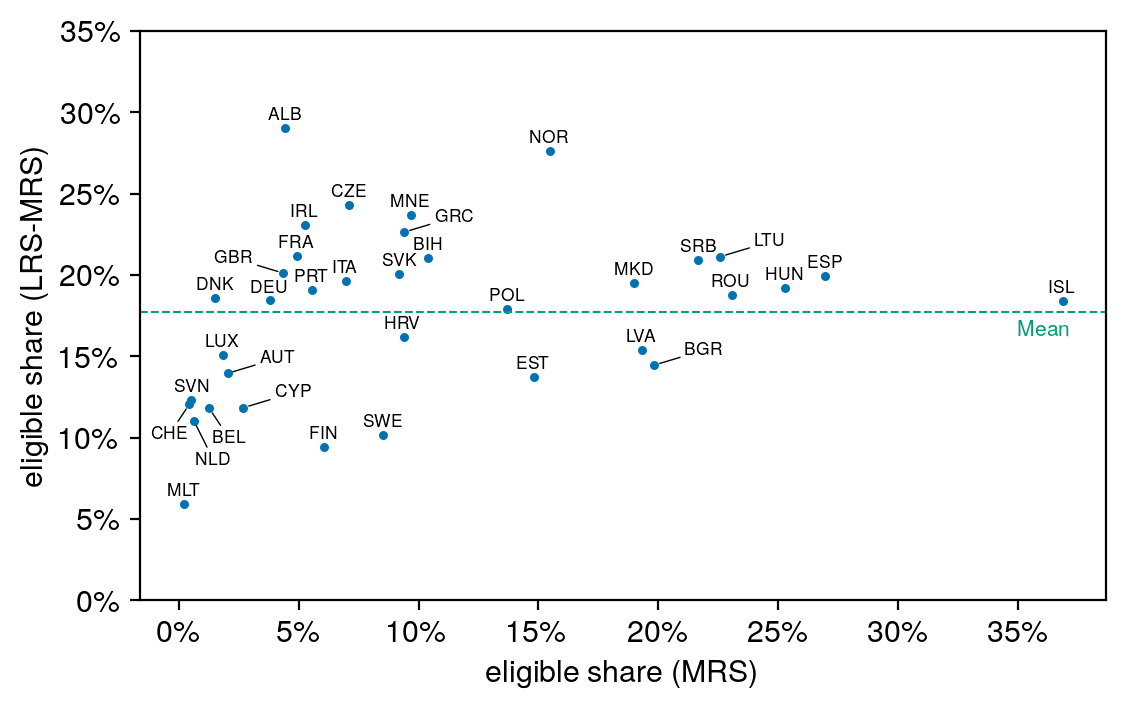

In [465]:
min_max.sort_values('diff').mean()

fig, ax = plt.subplots(figsize = figsize(1), dpi = 200)

ax.scatter(x = min_max.iloc[:,0]*100, y = min_max.iloc[:,2]*100, color = clrs['darkblue'], s = 5)
ax.set_ylim(0, 35)
#ax.set_xlim(right = 27)

ax.axhline(min_max.iloc[:,2].mean()*100, label = 'Mean', ls = '--', lw = 0.75, color = clrs['green'])

ax.annotate('Mean', (35, min_max.iloc[:,2].mean()*100), fontsize = 'x-small', xytext=(0,-25), textcoords="offset pixels", color = clrs['green'])

for i, txt in enumerate([countrycode[i] for i in countries]):
    
    if txt == 'BGR':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center',  va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'LTU':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'GRC':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'CYP':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'AUT':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'GBR':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(-50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))

        
    elif txt == 'NLD':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(20,-40),textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'CHE':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(-20,-30),textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
        
    elif txt == 'BEL':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(20,-30),textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))   
        
    else:   
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', xytext=(0,8), textcoords="offset pixels", fontsize = 'xx-small')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.set_xlabel('eligible share (MRS)')
ax.set_ylabel('eligible share (LRS-MRS)')

#ax.legend(loc = 'lower center', ncol = 3, bbox_to_anchor=(0.5, -0.3), frameon=False,  fontsize = 'small')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/landuse_min_max.png', dpi = 200)

### Fig. 5.2

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

do = False

if do == True:

    uf_d = {'High density urban fabric', 'Medium density urban fabric',
            'Low density urban fabric', 'Isolated or very low density urban fabric',
            'Urban vegetation', 'Industrial or commercial units', 'Major stations', 'Port areas'
            }
    
    d = {}

    for cntry in countries:
        
        print(cntry)

        country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
        exc = ExclusionContainer(res=50)
        exc.add_raster(LUISA, codes = [gridcodes['exclusion']['luisa'][x] for x in uf_d], crs=3035, invert = True)
        uf = geo.mte(exc, country.geometry, share_kind = 'normal')
        d[cntry] = {'uf_area' : uf[2], 'uf_share' : uf[3]}
        
        del uf
        
        exc = ExclusionContainer(res=50)
        exc.add_raster(LUISA, codes = [gridcodes['exclusion']['luisa']['Isolated or very low density urban fabric']], crs=3035, invert = True)
        uf = geo.mte(exc, country.geometry, share_kind = 'normal')
        d[cntry]['iuf_area'] = uf[2] 
        d[cntry]['iuf_share'] = uf[3]
        
        del uf
        
        exc = ExclusionContainer(res=50)
        exc.add_raster(LUISA, codes = [gridcodes['exclusion']['luisa'][x] for x in ['Medium density urban fabric', 'High density urban fabric']], crs=3035, invert = True)
        uf = geo.mte(exc, country.geometry, share_kind = 'normal')
        d[cntry]['huf_area'] = uf[2] 
        d[cntry]['huf_share'] = uf[3]
        
        del uf
        
    uf_analysis = pd.DataFrame.from_dict(d, orient = 'index', columns = ['uf_area', 'uf_share', 'iuf_area', 'iuf_share', 'huf_area', 'huf_share'])
    #uf_analysis.to_csv(ROOT + 'results/landuse_urban_fabric.csv')

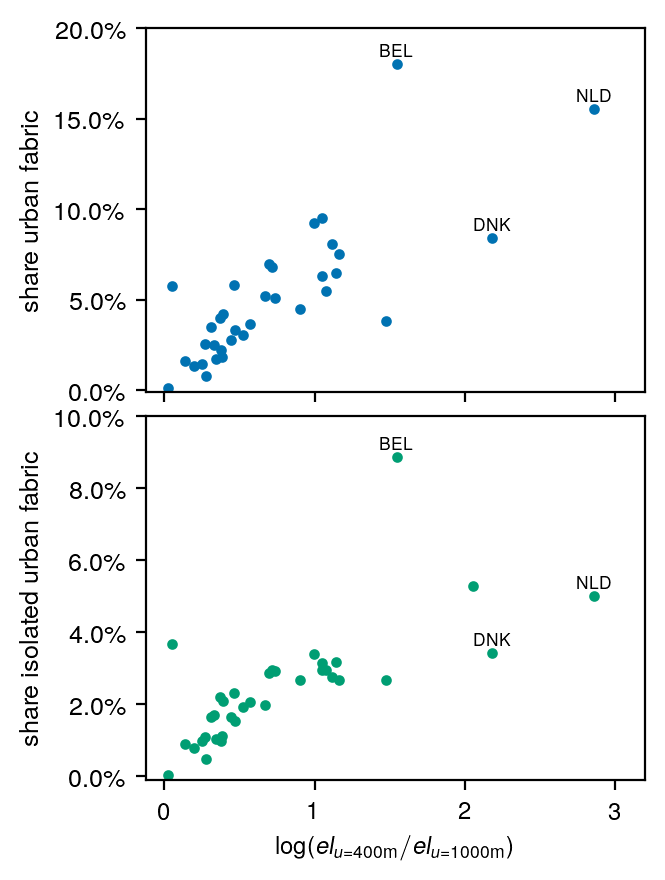

In [743]:
fig, ax = plt.subplots(2,1, figsize = (figsize(.575)[0], figsize(1)[1]*1.25), dpi = 200, sharex = True)

ax[0].scatter(y = uf_analysis.uf_share*100, x = np.log(lu_ud_mod.iloc[:,3]), color = clrs['darkblue'], s = 8)
ax[1].scatter(y = uf_analysis.iuf_share*100, x = np.log(lu_ud_mod.iloc[:,3]), color = clrs['green'], s = 8)

for i, txt in enumerate([countrycode[i] for i in countries]):
    if txt in ['NLD','DNK','BEL']:
        ax[0].annotate(txt, ((np.log(lu_ud_mod.iloc[:,3]))[i], (uf_analysis.uf_share*100)[i]), ha='center', xytext=(0,8), textcoords="offset pixels", fontsize = 'xx-small')
        ax[1].annotate(txt, ((np.log(lu_ud_mod.iloc[:,3]))[i], (uf_analysis.iuf_share*100)[i]), ha='center', xytext=(0,8), textcoords="offset pixels", fontsize = 'xx-small')

        
ax[0].set_ylabel('share urban fabric', size = 'small')
ax[1].set_ylabel('share isolated urban fabric', size = 'small')
ax[1].set_xlabel(r'$\log(el_{u\text{=400m}} / el_{u\text{=1000m}})$', size = 'small')


ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))


ax[0].set_ylim(bottom = -0.1, top=20)
ax[1].set_ylim(bottom = -0.1, top=10)


ax[0].set_xlim(right=3.2)
ax[1].set_xlim(right=3.2)



ax[0].tick_params(labelsize='small')
ax[1].tick_params(labelsize='small')

fig.tight_layout(pad=0.05)
fig.savefig(ROOT + 'results/plots/ud_scatter.png', dpi = 200)

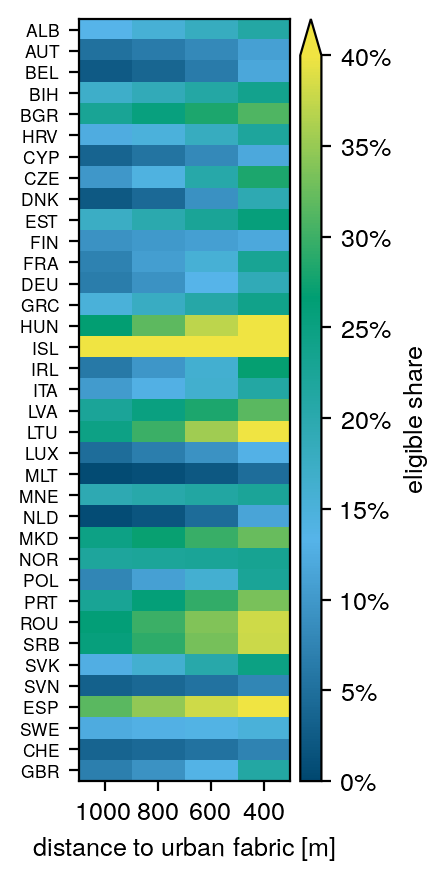

In [724]:
cmap = pltc.LinearSegmentedColormap.from_list(
    "", [lighten_color(clrs['darkblue'],1.2), clrs['lightblue'], clrs['green'], clrs['yellow']]
)


fig, ax = plt.subplots(dpi = 200, figsize = ((figsize(.375)[0], figsize(1)[1]*1.25)))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.05)


im = ax.imshow(lu_ud.iloc[:,::-1]*100, cmap=cmap, vmin = 0, vmax = 40, aspect = 'auto')
ax.set_yticks(range(len(countries)), [countrycode[i] for i in lu_ud.index], size = 'xx-small')
ax.set_xticks([0,1,2,3], ['1000','800','600','400'], size = 'small')
ax.set_xlabel('distance to urban fabric [m]', size = 'small')
#ax.set_title('Area gain over 1000m distance')

cb = fig.colorbar(im, cax=cax, orientation='vertical', extend = 'max', format =  mtick.PercentFormatter(decimals=0))
cb.set_label(label='eligible share', fontsize = 'small')
cb.ax.tick_params(labelsize='small')

fig.tight_layout(pad=0.05)
fig.savefig(ROOT + 'results/plots/ud_heat.png', dpi = 200)

### Fig. 5.3

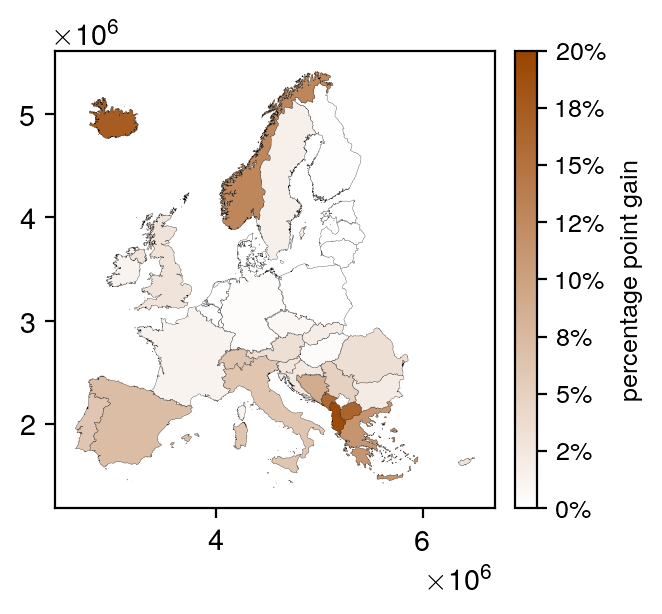

In [714]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['orange'], 1.2)])

fig, ax = plt.subplots(figsize = (figsize(.575)[0], figsize(1)[1]*1.25), dpi = 200)


divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


for cntry in countries:
    country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    country['gain'] = (lu_slope.iloc[:,1]-lu_slope.iloc[:,0]).loc[cntry] * 100
    if cntry == countries[0]:
        country.plot('gain', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 20, legend = True, ax = ax, cax=cax)

    else:
        country.plot('gain', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 20, legend = False, ax = ax)
        
cax.set_ylabel('percentage point gain', fontsize = 'small')
cax.tick_params(labelsize='small')
cax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
#ax.set_title('Gain')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/slope_gain.pdf')

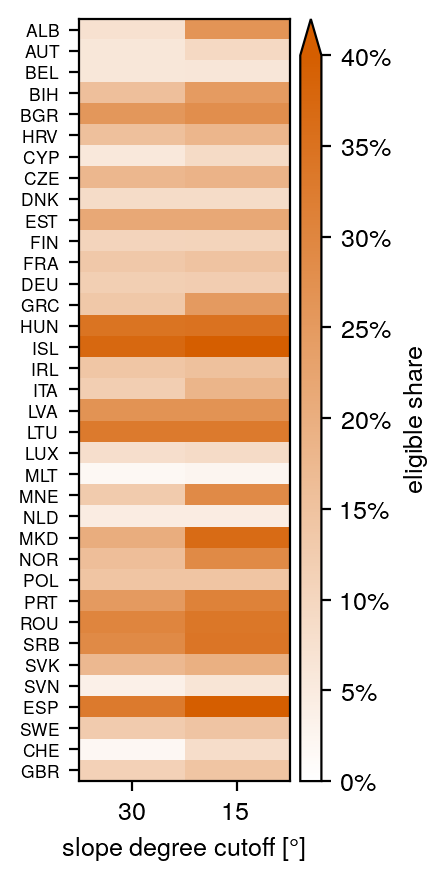

In [723]:
cmap = pltc.LinearSegmentedColormap.from_list(
    "", ['white', clrs['orange']]
)


fig, ax = plt.subplots(dpi = 200, figsize = ((figsize(.375)[0], figsize(1)[1]*1.25)))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.05)


im = ax.imshow(lu_slope *100, cmap=cmap, vmin = 0, vmax = 40, aspect = 'auto')
ax.set_yticks(range(len(countries)), [countrycode[i] for i in lu_slope.index], size = 'xx-small')
ax.set_xticks([0,1], ['30','15'], size = 'small')
ax.set_xlabel('slope degree cutoff [°]', size = 'small')
#ax.set_title('Area gain over 1000m distance')

cb = fig.colorbar(im, cax=cax, orientation='vertical', extend = 'max', format =  mtick.PercentFormatter(decimals=0))
cb.set_label(label='eligible share', fontsize = 'small')
cb.ax.tick_params(labelsize='small')

fig.tight_layout(pad=0.05)
fig.savefig(ROOT + 'results/plots/slope_heat.png', dpi = 200)

In [334]:
lu_slope['diff'] = lu_slope.iloc[:,1] - lu_slope.iloc[:,0]

In [337]:
lu_slope.sort_values('diff', ascending = False)

v_share                diff
slope                         15        30          
country                                             
Albania                 0.074117  0.265621  0.191504
Iceland                 0.373475  0.546556  0.173081
North Macedonia         0.201861  0.367145  0.165284
Montenegro              0.128900  0.288717  0.159817
Norway                  0.160485  0.289179  0.128694
Greece                  0.137238  0.249952  0.112714
Bosnia and Herzegovina  0.157022  0.245875  0.088854
Spain                   0.329539  0.400046  0.070507
Switzerland             0.019942  0.083099  0.063158
Italy                   0.121761  0.183028  0.061267
Portugal                0.248944  0.309247  0.060303
Serbia                  0.289747  0.339274  0.049528
Romania                 0.302701  0.336466  0.033765
Austria                 0.060373  0.094130  0.033757
Cyprus                  0.057658  0.090179  0.032521
United Kingdom          0.113229  0.142996  0.029767
Slovenia                0.037011  0.064916  0.027905
Croatia                 0.156037  0.180734  0.024697
Bulgaria                0.257777  0.278934  0.021157
Slovakia                0.174928  0.195723  0.020795
Sweden                  0.126965  0.143860  0.016895
Ireland                 0.140664  0.154048  0.013384
France                  0.134592  0.147772  0.013181
Czech Republic          0.178000  0.186909  0.008909
Luxembourg              0.081058  0.088915  0.007857
Malta                   0.018118  0.024662  0.006544
Hungary                 0.344512  0.348653  0.004141
Germany                 0.118984  0.122843  0.003859
Belgium                 0.060880  0.062115  0.001236
Finland                 0.105303  0.106274  0.000971
Poland                  0.142716  0.143258  0.000542
Latvia                  0.268228  0.268595  0.000367
Lithuania               0.329130  0.329464  0.000334
Estonia                 0.214347  0.214617  0.000271
Denmark                 0.087306  0.087440  0.000134
Netherlands             0.046424  0.046462  0.000038

### Tab. 5.2 

In [ ]:
from scipy import stats
from rasterio.features import rasterize

do = True

if do:
    
    s = {}

    for cntry in countries: 

        print(cntry)

        country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)

        with rio.open(ROOT + 'data/input_geodata/EUD_CP_SLOP_mosaic/eudem_slop_3035_europe.tif', 'r') as src:
            window = from_bounds(country.bounds['minx'].values, country.bounds['miny'].values, country.bounds['maxx'].values, country.bounds['maxy'].values, src.transform)
            d = src.read(1, window=window)
            r_shape = d.shape
            r_transform = rio.windows.transform(window, src.transform)
            
        data = rasterize(
            country.geometry,
            out_shape=r_shape,
            transform=r_transform,
            dtype='uint8'
        )
        
        m = np.mean((d*data)[(d*data) > 0])                      
        d15 = stats.percentileofscore((d*data)[(d*data) > 0].flatten(), score = 241)
        d30 = stats.percentileofscore((d*data)[(d*data) > 0].flatten(), score = 217)
        s[cntry] = [geo.dn_to_degrees(m), 100-d15, 100-d30] 

    s = pd.DataFrame(s).T
    s.columns = ['slope_mean', 'q_15', 'q_30']
    s['diff'] = s['q_30'] - s['q_15']


### Fig. 5.4

In [728]:
from itertools import product
fshares = [0,5,10]
lshares = [0,5,10]

d = {}

for f,l in [(0,0), (5,0), (10,0), (0,5), (0,10), (5,5), (5,10), (10,5), (10,10)]: 
    d[f'(F{f}, L{l})'] = lu[(lu['fshare']==f) & (lu['lshare']==l)].groupby('country').mean()['v_share']

d = pd.DataFrame(d)
      

In [729]:
def divide_by_first(row):
    return (row - row[0]) 
    
d_mod = d.apply(divide_by_first, axis=1)
d_mod = d_mod.drop('(F0, L0)', axis = 1)

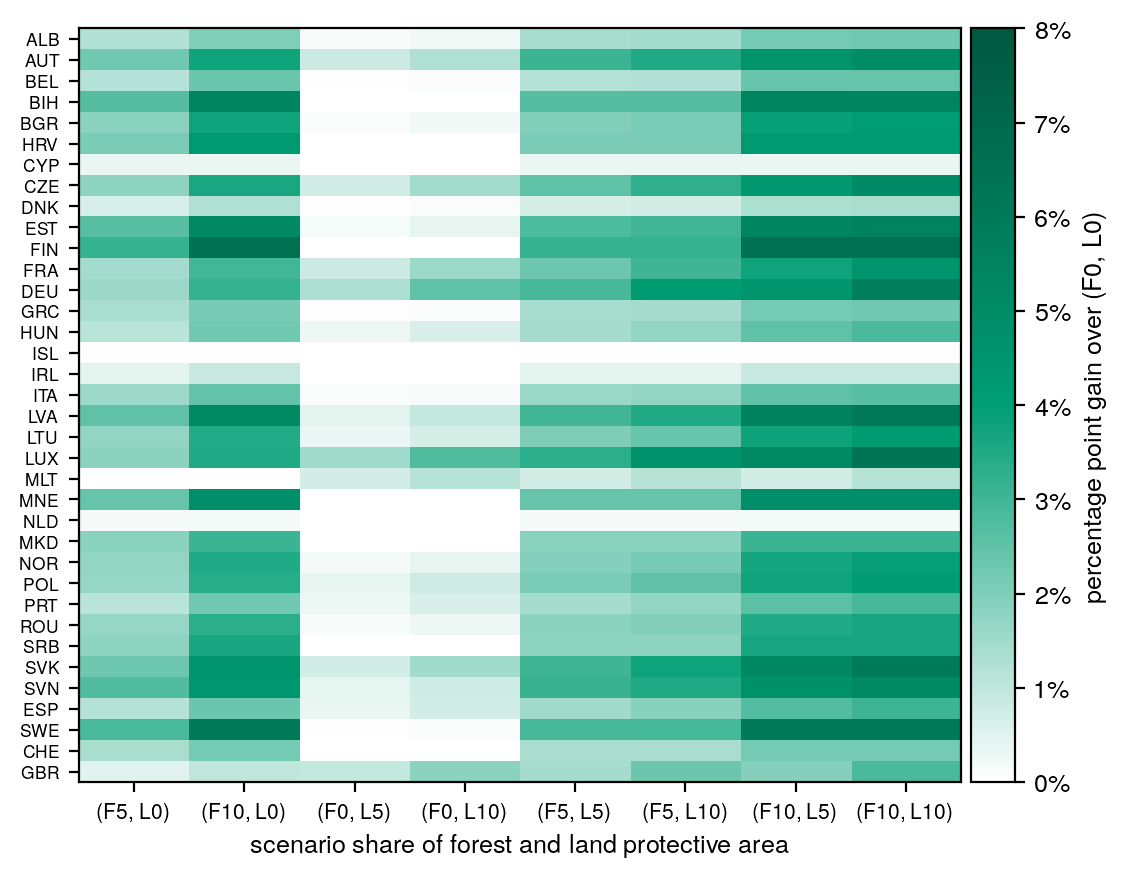

In [730]:
cmap = pltc.LinearSegmentedColormap.from_list(
    "", ['white', clrs['green'], lighten_color(clrs['green'], 1.2)]
)


fig, ax = plt.subplots(dpi = 200, figsize = ((figsize(1)[0], figsize(1)[1]*1.25)))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)


im = ax.imshow(d_mod *100, cmap=cmap, vmin = 0, vmax = 8, aspect = 'auto')
ax.set_yticks(range(len(countries)), [countrycode[i] for i in d_mod.index], size = 'xx-small')
ax.set_xticks([0,1,2,3,4,5,6,7], d_mod.columns, size = 'x-small')
ax.set_xlabel('scenario share of forest and land protective area', fontsize = 'small')


cb = fig.colorbar(im, cax=cax, orientation='vertical', format =  mtick.PercentFormatter(decimals=0))
cb.set_label(label='percentage point gain over (F0, L0)', fontsize = 'small')
cb.ax.tick_params(labelsize='small')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/forest_lpa_heat.png', dpi = 200)

### Fig. 5.5

In [ ]:
import glob 
import fiona 
from itertools import product

uds = ['1000' , '800', '600', '400']
ss = ['30', '15']
fs = ['0', '5', '10']
ls = ['0', '5', '10']
ts = ['Vestas_V90_3MW-Vestas_V112_3MW', 'W2E_151_4800kW-W2E_165_5200kW']

tps = []


with open(ROOT + "/windgenpotential/countrycode.yaml", 'r') as stream:
    countrycode = yaml.safe_load(stream)  

countries = [i for i in countrycode.keys()]
      
for cntry in countries:
    
    print(cntry)
    
    for ud, s, f, l in product(uds, ss, fs, ls):
        
        with rio.open(ROOT + f'data/country_landuse_results/{cntry}-base-{ud}-{s}-{f}-{l}.tif') as src:
            v = src.read(1)
            src.close()
            area = v.sum() * 50**2
        
        for t in ts:
            file = ROOT + f'data/country_turbine_placements/{cntry}-base-{ud}-{s}-{f}-{l}-{t}.gpkg'
            d = fiona.open(file, 'r')     
            rows = len(d)
            d.close()

            tps.append([cntry, ud, s, f, l, t, area, rows])  
            


In [6]:
tps_df = pd.DataFrame(tps, columns = ['country', 'ud', 'slope', 'fshare', 'lshare', 'turbine', 'area', 'placements'])
#tps_df.to_csv(ROOT + 'results/turbine_placements.csv')

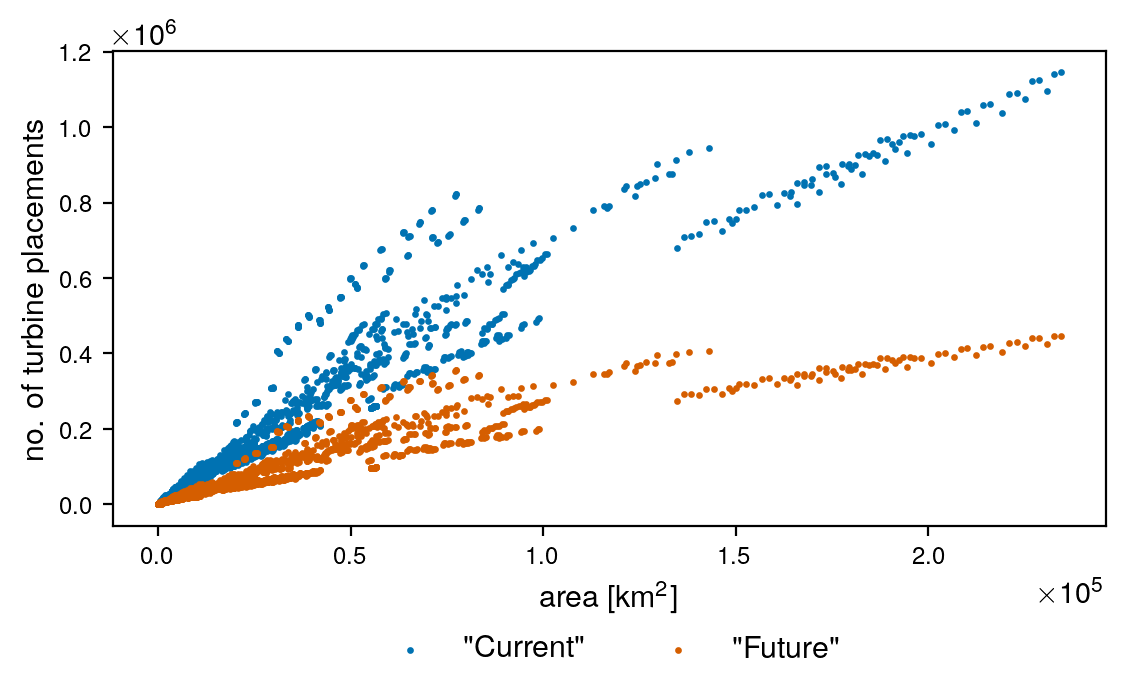

In [28]:
fig, ax = plt.subplots(figsize = figsize (1), dpi = 200)

ax.scatter(x = tps_df[tps_df['turbine'] == ts[0]].area/1000000, y = tps_df[tps_df['turbine'] == ts[0]].placements, s = 2, label = '"Current"')
ax.scatter(x = tps_df[tps_df['turbine'] == ts[1]].area/1000000, y = tps_df[tps_df['turbine'] == ts[1]].placements, s = 2, label = '"Future"', color = clrs['orange'])

ax.set_xlabel(r'area [km$\textsuperscript{2}$]')
ax.set_ylabel('no. of turbine placements')
ax.tick_params(labelsize='small')

ax.legend(loc = 'lower center', ncol = 2, bbox_to_anchor=(0.5, -0.35), frameon=False)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/t_placement_area.pdf', dpi = 200)

### Tab. 5.3

In [7]:
import statsmodels.api as sm

In [ ]:
tps_stats = tps_df[['country','placements', 'area']]
tps_stats['area'] = tps_stats['area']/1000000

tps_stats['turbine_dummy'] = (tps_df['turbine'] == 'Vestas_V90_3MW-Vestas_V112_3MW').astype(int)
tps_stats['turbine_dummy_area'] = tps_stats['turbine_dummy'] * tps_stats['area']

tps_stats = pd.get_dummies(tps_stats, columns=['country'])

In [10]:
#define response variable
y = tps_stats['placements'] 

In [11]:
import statsmodels.api as sm

#define predictor variables
x = tps_stats['area']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             placements   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                 1.175e+04
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        03:06:41   Log-Likelihood:                -66768.
No. Observations:                5184   AIC:                         1.335e+05
Df Residuals:                    5182   BIC:                         1.336e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.831e+04   1657.534     11.044      0.0

In [12]:
x = tps_stats[['area','turbine_dummy_area']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             placements   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                 2.267e+04
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        03:06:41   Log-Likelihood:                -63934.
No. Observations:                5184   AIC:                         1.279e+05
Df Residuals:                    5181   BIC:                         1.279e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.831e+04    959

In [13]:
x = tps_stats.drop(['placements', 'turbine_dummy', 'turbine_dummy_area'], axis = 1)

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             placements   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     492.5
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        03:06:42   Log-Likelihood:                -65971.
No. Observations:                5184   AIC:                         1.320e+05
Df Residuals:                    5147   BIC:                         1.323e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [14]:
x = tps_stats.drop(['placements', 'turbine_dummy'], axis = 1)

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             placements   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     6322.
Date:                Wed, 28 Dec 2022   Prob (F-statistic):               0.00
Time:                        03:06:42   Log-Likelihood:                -59888.
No. Observations:                5184   AIC:                         1.199e+05
Df Residuals:                    5146   BIC:                         1.201e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### Fig. 5.6

In [118]:
with rio.open(ROOT + 'data/country_landuse_results/Finland-base-1000-15-0-0.tif', 'r') as src:
    fin0 = src.read(1)
    tf = src.transform
    src.close()
    
with rio.open(ROOT + 'data/country_landuse_results/Finland-base-1000-15-5-5.tif', 'r') as src:
    fin1 = src.read(1)
    tf = src.transform
    src.close()

In [ ]:
with rio.open(ROOT + 'data/country_landuse_results/Romania-base-1000-15-0-0.tif', 'r') as src:
    ro0 = src.read(1)
    rf = src.transform
    src.close()
    
with rio.open(ROOT + 'data/country_landuse_results/Romania-base-1000-15-10-10.tif', 'r') as src:
    ro1 = src.read(1)
    rf = src.transform
    src.close()

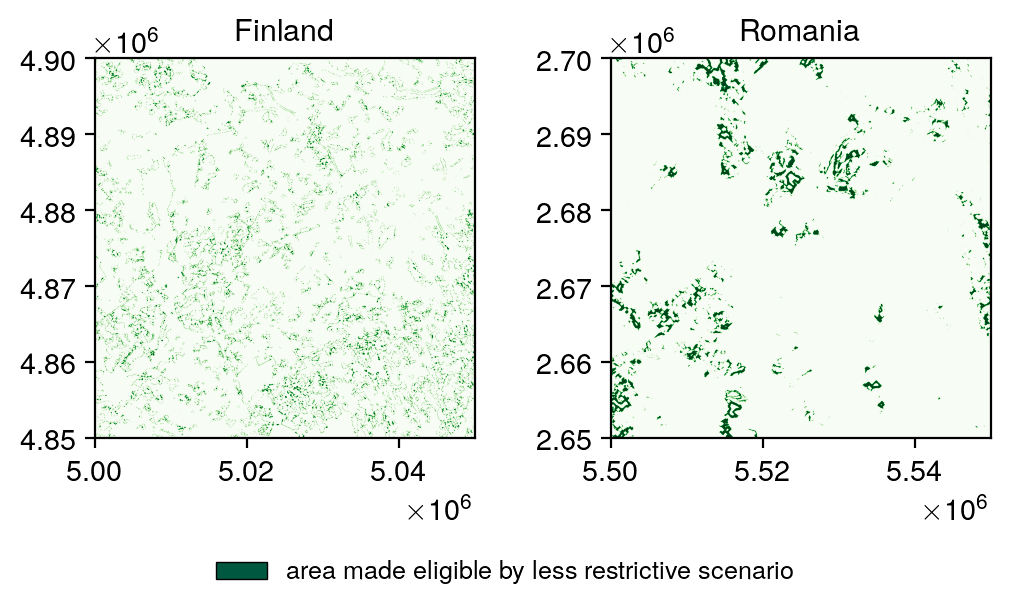

In [155]:
cmap = pltc.LinearSegmentedColormap.from_list(
    "", ['white', lighten_color(clrs['green'], 1.2)]
)

fig, ax = plt.subplots(1, 2, figsize = figsize(1), dpi = 200)

show(fin1-fin0, transform = tf, cmap = 'Greens', ax = ax[0] ) 
ax[0].set_ylim(4850000, 4900000)
ax[0].set_xlim(5000000, 5050000)
ax[0].set_title('Finland')

show(ro1-ro0, transform = rf, cmap = 'Greens', ax = ax[1] ) 
ax[1].set_ylim(2650000, 2700000)
ax[1].set_xlim(5500000, 5550000)
ax[1].set_title('Romania')


txt = 'area made eligible by less restrictive scenario' 

patches = [mpatches.Patch(facecolor=c, edgecolor = 'k', lw = .5, label=l) for l,c in zip([txt],[lighten_color(clrs['green'], 1.2)])]   
fig.legend(handles = patches, loc = 'lower center', ncol = 1, bbox_to_anchor=(.5, -0.015), frameon=False,  fontsize = 'small')

fig.tight_layout(pad = 2)
fig.savefig(ROOT + 'results/plots/structure.pdf', dpi = 200)


### Tab. 5.4

In [ ]:
from itertools import product

with open("countrycode.yaml", 'r') as stream:
    countrycode = yaml.safe_load(stream)  
    
countries = countrycode.keys(); countries = list(countries)

uds = ['1000' , '800', '600', '400']
ss = ['30', '15']
fs = ['0', '5', '10']
ls = ['0', '5', '10']
ts = ['Vestas_V90_3MW-Vestas_V112_3MW', 'W2E_151_4800kW-W2E_165_5200kW']

do = True

if do:

    res = []

    for cntry in countries:

        print(cntry)

        for ud, s, f, l, t in product(uds, ss, fs, ls, ts):

            with pd.HDFStore(ROOT + f'data/country_generation_potential/{cntry}.h5') as hdf:
                d = hdf.get(f'base-{ud}-{s}-{f}-{l}-{t}')

            tech_potential = d.resample('Y').sum().sum(axis=1) / 1000
            stats = [tech_potential.mean(), tech_potential.std(), tech_potential.min(), tech_potential.max()]
            
            res.append([cntry, ud, s, f, l, t, *stats])
            
    cols = ['country', 'urban_d', 'slope', 'fshare', 'lshare', 'turbine', 'tp_y_mean', 'tp_y_std', 'tp_y_min', 'tp_y_max']
    res_df = pd.DataFrame(res, columns = cols)

In [552]:
res_df['tp_y_mean_area'] = res_df['tp_y_mean'].divide(tps_df['area'], axis = 0)

In [585]:
summary = pd.concat([res_df.groupby('country').mean()['tp_y_mean'].rename('mean'),
               res_df.groupby('country').std()['tp_y_mean'].rename('std'),
               res_df.groupby('country').min()['tp_y_mean'].rename('min'),
               res_df.groupby('country').max()['tp_y_mean'].rename('max'),
               res_df.groupby('country').mean()['tp_y_mean_area'].rename('mean_el_area'),
                    ], axis = 1).divide(1000)
summary['mean_el_area'] = summary['mean_el_area']*1000000*1000

ls = []

for cntry in countries:
    area = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    ls.append(summary.loc[cntry,'mean'] / area.geometry.area.values[0])
summary['mean_tot_area'] = pd.Series(ls, index = summary.index) *1000000*1000

In [582]:
#res_df.to_csv(ROOT + 'results/technical_potential.csv')
#round(summary, 2).to_csv(ROOT + 'results/technical_potential_summary.csv')

### Fig. 5.7

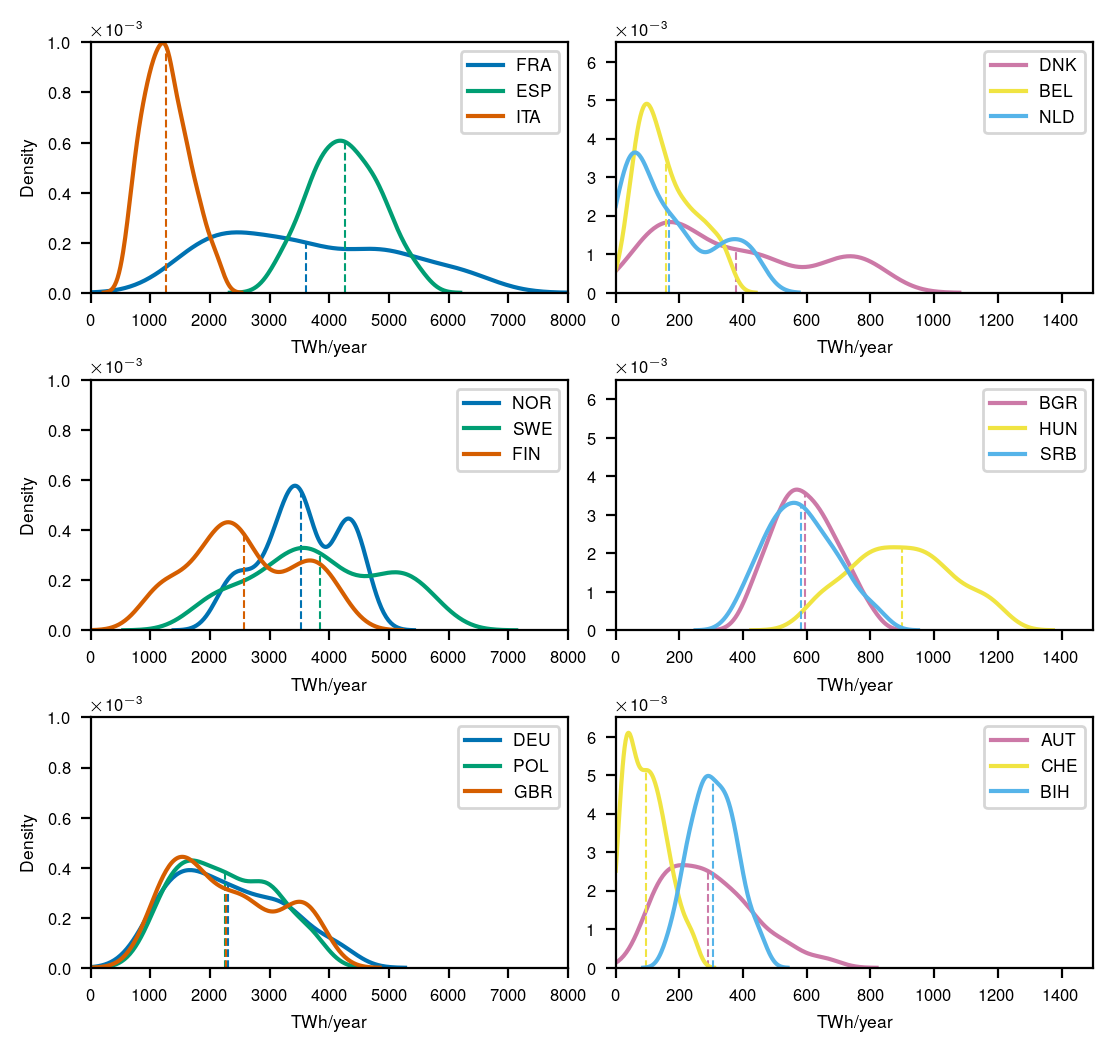

In [703]:
import seaborn as sns

fig, ax = plt.subplots(3,2,figsize = (figsize(1)[0], figsize(1)[1] * 1.5), dpi = 200, sharey = False)

for n,cntry in enumerate(['France', 'Spain', 'Italy']):
    
    color = list(clrs.values())[n]
    d_vec = res_df[res_df['country'] == cntry].tp_y_mean / 1000
    sns.kdeplot(d_vec, label = countrycode[cntry], clip=(0,10000), color = color, bw_adjust = 1, ax = ax[0,0])
    
    kdeline = ax[0,0].lines[n]
    mean = d_vec.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax[0,0].vlines(mean, 0, height, color=color, ls='--', lw = .75)
    ax[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[0,0].legend(fontsize = 'xx-small')
    ax[0,0].set_xlabel(None)
    ax[0,0].set_ylabel('Density',  fontsize = 'xx-small')
    ax[0,0].set_xlabel('TWh/year', fontsize = 'xx-small')
    ax[0,0].tick_params(axis='both', which = 'both', labelsize='xx-small')
    ax[0,0].set_xlim(0,8000)
    ax[0,0].set_ylim(0,0.001)
    ax[0,0].yaxis.offsetText.set_fontsize('xx-small')
    
    
for n,cntry in enumerate(['Norway' , 'Sweden', 'Finland']):
    
    color = list(clrs.values())[n]
    d_vec = res_df[res_df['country'] == cntry].tp_y_mean / 1000
    sns.kdeplot(d_vec, label = countrycode[cntry], clip=(0,10000), color = color, bw_adjust = 1, ax = ax[1,0])
    
    kdeline = ax[1,0].lines[n]
    mean = d_vec.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax[1,0].vlines(mean, 0, height, color=color, ls='--', lw = .75)
    ax[1,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[1,0].legend(fontsize = 'xx-small')
    ax[1,0].set_xlabel(None)
    ax[1,0].set_ylabel('Density',  fontsize = 'xx-small')
    ax[1,0].set_xlabel('TWh/year', fontsize = 'xx-small')
    ax[1,0].tick_params(axis='both',labelsize='xx-small')
    ax[1,0].set_xlim(0,8000)
    ax[1,0].set_ylim(0,0.001)
    ax[1,0].yaxis.offsetText.set_fontsize('xx-small')
    
for n,cntry in enumerate(['Germany' , 'Poland', 'United Kingdom']):
    
    color = list(clrs.values())[n]
    d_vec = res_df[res_df['country'] == cntry].tp_y_mean / 1000
    sns.kdeplot(d_vec, label = countrycode[cntry], clip=(0,10000), color = color, bw_adjust = 1, ax = ax[2,0])
    
    kdeline = ax[2,0].lines[n]
    mean = d_vec.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax[2,0].vlines(mean, 0, height, color=color, ls='--', lw = .75)
    ax[2,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[2,0].legend(fontsize = 'xx-small')
    ax[2,0].set_xlabel('TWh/year', fontsize = 'xx-small')
    ax[2,0].tick_params(axis='both',labelsize='xx-small')
    ax[2,0].set_ylabel('Density',  fontsize = 'xx-small')
    ax[2,0].set_xlim(0,8000)
    ax[2,0].set_ylim(0,0.001)
    ax[2,0].yaxis.offsetText.set_fontsize('xx-small')

    
for n,cntry in enumerate(['Denmark', 'Belgium', 'Netherlands']):
    
    color = list(clrs.values())[n+3]
    d_vec = res_df[res_df['country'] == cntry].tp_y_mean / 1000
    sns.kdeplot(d_vec, label = countrycode[cntry], clip=(0,10000), color = color, bw_adjust = 1, ax = ax[0,1])
    
    kdeline = ax[0,1].lines[n]
    mean = d_vec.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax[0,1].vlines(mean, 0, height, color=color, ls='--', lw = .75)
    ax[0,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[0,1].legend(fontsize = 'xx-small')
    ax[0,1].set_xlabel('TWh/year', fontsize = 'xx-small')
    ax[0,1].tick_params(axis='both',labelsize='xx-small')
    ax[0,1].set_ylabel(None)
    ax[0,1].set_xlim(0,1500)
    ax[0,1].set_ylim(0,0.0065)
    ax[0,1].yaxis.offsetText.set_fontsize('xx-small')
    
for n,cntry in enumerate(['Bulgaria', 'Hungary', 'Serbia']):
    
    color = list(clrs.values())[n+3]
    d_vec = res_df[res_df['country'] == cntry].tp_y_mean / 1000
    sns.kdeplot(d_vec, label = countrycode[cntry], clip=(0,10000), color = color, bw_adjust = 1, ax = ax[1,1])
    
    kdeline = ax[1,1].lines[n]
    mean = d_vec.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax[1,1].vlines(mean, 0, height, color=color, ls='--', lw = .75)
    ax[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[1,1].legend(fontsize = 'xx-small')
    ax[1,1].set_xlabel('TWh/year', fontsize = 'xx-small')
    ax[1,1].tick_params(axis='both',labelsize='xx-small')
    ax[1,1].set_ylabel(None)
    ax[1,1].set_xlim(0,1500)
    ax[1,1].set_ylim(0,0.0065)
    ax[1,1].yaxis.offsetText.set_fontsize('xx-small')
    
for n,cntry in enumerate(['Austria', 'Switzerland', 'Bosnia and Herzegovina']):
    
    color = list(clrs.values())[n+3]
    d_vec = res_df[res_df['country'] == cntry].tp_y_mean / 1000
    sns.kdeplot(d_vec, label = countrycode[cntry], clip=(0,10000), color = color, bw_adjust = 1, ax = ax[2,1])
    
    kdeline = ax[2,1].lines[n]
    mean = d_vec.mean()
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(mean, xs, ys)
    ax[2,1].vlines(mean, 0, height, color=color, ls='--', lw = .75)
    ax[2,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[2,1].legend(fontsize = 'xx-small')
    ax[2,1].set_xlabel('TWh/year', fontsize = 'xx-small')
    ax[2,1].set_ylabel(None)
    ax[2,1].tick_params(axis='both',labelsize='xx-small')
    ax[2,1].set_xlim(0,1500)
    ax[2,1].set_ylim(0,0.0065)
    ax[2,1].yaxis.offsetText.set_fontsize('xx-small')
    
fig.tight_layout(pad = 0.01)
fig.savefig(ROOT + 'results/plots/result_densities.pdf', dpi  = 300)



### Tab. 5.5

In [859]:
a = res_df.groupby(['country','urban_d']).mean().tp_y_mean.unstack()
a = a[['1000', '800', '600', '400']]
def divide_by_first(row):
    return (row / row[0]) 
a = a.apply(divide_by_first, axis=1)
a = (a*100-100).iloc[:,1:]


b = res_df.groupby(['country','slope']).mean().tp_y_mean.unstack()
b = b[['15','30']]
def divide_by_first(row):
    return (row / row[0]) 
b = b.apply(divide_by_first, axis=1)
b = (b*100-100).iloc[:,1:]

c = res_df.groupby(['country','fshare']).mean().tp_y_mean.unstack()
c = c[['0','5', '10']]
def divide_by_first(row):
    return (row / row[0]) 
c = c.apply(divide_by_first, axis=1)
c = (c*100-100).iloc[:,1:]

d = res_df.groupby(['country','lshare']).mean().tp_y_mean.unstack()
d = d[['0','5', '10']]
def divide_by_first(row):
    return (row / row[0]) 
d = d.apply(divide_by_first, axis=1)
d = (d*100-100).iloc[:,1:]

e = res_df.groupby(['country','turbine']).mean().tp_y_mean.unstack()
e = e[[res_df.turbine.unique()[0], res_df.turbine.unique()[1]]]
def divide_by_first(row):
    return (row / row[0]) 
e = e.apply(divide_by_first, axis=1)
e = (e*100-100).iloc[:,1:]

e = res_df.groupby(['country','turbine']).mean().tp_y_mean.unstack()
e = e[[res_df.turbine.unique()[0], res_df.turbine.unique()[1]]]
def divide_by_first(row):
    return (row / row[0]) 
e = e.apply(divide_by_first, axis=1)
e = (e*100-100).iloc[:,1:]

f = round(pd.concat([a,b,c,d,e], axis = 1),2)

mean = f.mean()
std = f.std()

f = round(pd.concat([f,pd.DataFrame(mean).T]),2)
f = round(pd.concat([f,pd.DataFrame(std).T]),2)

In [861]:
f.to_csv(ROOT + 'results/sensitivities.csv')

### Fig. 5.8

In [1257]:
ryberg = pd.read_csv(ROOT + 'results/results_ryberg.csv', sep = ';', decimal = ',', index_col = 'Region')
ryberg = ryberg.reindex(sorted(ryberg.index)) 

In [1264]:
mckenna = pd.read_csv(ROOT + 'results/results_mckenna.csv', sep = ';', decimal = ',', index_col = 'Country')
mckenna = mckenna.reindex(sorted(mckenna.index)) 

In [1077]:
ryberg_comp_tps = tps_df.query(f"(ud == '1000') & (slope == '15') & (fshare == '10') & (lshare == '10') & (turbine == '{res_df.turbine.unique()[1]}')")
ryberg_comp_res = res_df.query(f"(urban_d == '1000') & (slope == '15') & (fshare == '10') & (lshare == '10') & (turbine == '{res_df.turbine.unique()[1]}')")

ryberg_comp_tps.set_index('country', inplace = True)
ryberg_comp_res.set_index('country', inplace = True)

In [1235]:
ryberg_comp = pd.concat([
([res_df.groupby('country').min().loc[cntry, 'tp_y_mean'] for cntry in ryberg.index] / (ryberg.TWh*1000)),
([res_df.groupby('country').max().loc[cntry, 'tp_y_mean'] for cntry in ryberg.index] / (ryberg.TWh*1000)),
([res_df.groupby('country').mean().loc[cntry, 'tp_y_mean'] for cntry in ryberg.index] / (ryberg.TWh*1000)),
([res_df.groupby(['country', 'urban_d']).mean().query("urban_d == '1000'").loc[(cntry, '1000'), 'tp_y_mean'] for cntry in ryberg.index] / (ryberg.TWh*1000)),
([res_df.groupby(['country', 'urban_d']).mean().query("urban_d == '800'").loc[(cntry, '800'), 'tp_y_mean'] for cntry in ryberg.index] / (ryberg.TWh*1000)),
([res_df.groupby(['country', 'urban_d']).mean().query("urban_d == '600'").loc[(cntry, '600'), 'tp_y_mean'] for cntry in ryberg.index] / (ryberg.TWh*1000)),
([res_df.groupby(['country', 'urban_d']).mean().query("urban_d == '400'").loc[(cntry, '400'), 'tp_y_mean'] for cntry in ryberg.index] / (ryberg.TWh*1000)),
([res_df.groupby('country').median().loc[cntry, 'tp_y_mean'] for cntry in ryberg.index] / (ryberg.TWh*1000)) 
], axis = 1)
ryberg_comp.columns = ['min', 'max', 'mean', 'mean1000', 'mean800', 'mean600', 'mean400', 'median']
ryberg_comp = ryberg_comp-1

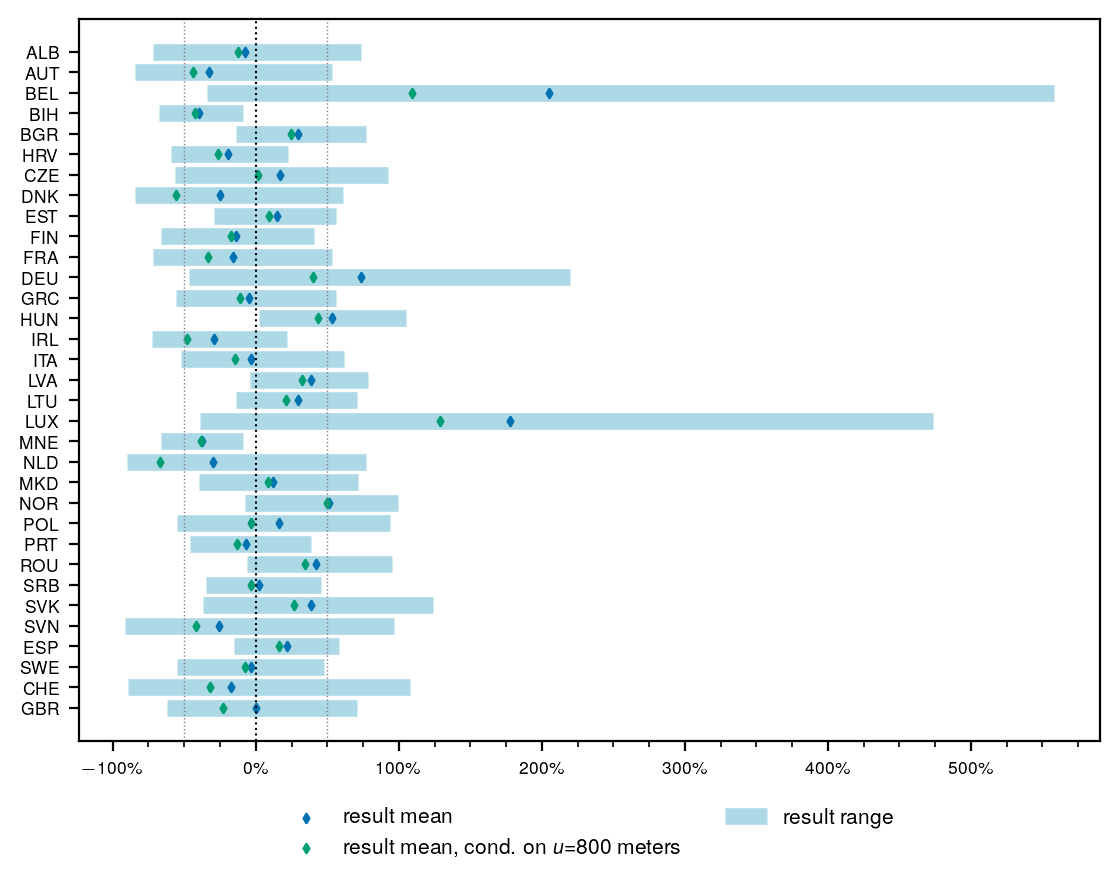

In [1226]:
fig, ax = plt.subplots(figsize = (figsize(1)[0], figsize(1)[1]*1.25), dpi = 200)

data = ryberg_comp[::-1]*100

l1 = 'result range'
l2 = 'result mean' 
l3 = r'result mean, cond. on $u$=800 meters'

ax.scatter(y = data.index, x = data['mean'], label = l2, marker = 'd', s = 5)
ax.scatter(y = data.index, x = data['mean800'], label = l3, marker = 'd', s = 5)
ax.hlines(y = data.index, xmin= data['min'], xmax =data['max'], lw = 6, zorder = 0, color = 'lightblue', label = l1)


ax.set_yticks(range(len(data)), [countrycode[i] for i in data.index], size = 'xx-small')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.xaxis.set_minor_locator(mtick.MultipleLocator(25))
ax.tick_params(labelsize = 'xx-small')



ax.axvline(0, color = 'k', ls = 'dotted', lw = 0.75)
ax.axvline(-50, color = 'grey', ls = 'dotted', lw = 0.5)
ax.axvline(50, color = 'grey', ls = 'dotted', lw = 0.5)

ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.19), ncol=2, frameon=False,  fontsize = 'x-small')

fig.tight_layout(pad = .2)
fig.savefig(ROOT + 'results/plots/ryberg_comp.pdf')